# Classificação Vinho Verrmelho

In [1]:
# PARÂMETROS
random_seed = 42
my_class = 'good' # good, bad

# FEATURE SELECTION
center_stat = 'median'
select_by_center_stat = True
x_cols = ['alcohol', 'volatile acidity']

# FOLDING
n_k_folds = 5

# MODEL SELECTION
n_std_lower_bound = 3
change_operation_point = True

# TREES
tree_criteria = 'entropy'
tree_hyperparameter = 'max_depth'
decision_tree_min_samples_leaf_range = range(15, 21)
decision_tree_max_depth = range(2, 5)

# RANDOM FOREST
n_estimators = range(2, 5)

# NEURAL NETWORK
optimizer = 'adam'
activation = 'tanh'
loss = 'mse'
metric = 'accuracy'
min_improvement = 0.001
batch_size = None
patience = 300
max_epochs = 10*patience
learning_rate = 0.005
n_hidden_layers_range = range(2, 6)
verbose = 0

# BOOLEANS FOR SELECTING MODELS
train_lr = True
train_lda = True
train_qda = True
train_tree = True
train_forest = True
train_nn = True

In [2]:
import keras
import numpy
import pandas
import seaborn
import tensorflow
from matplotlib import pyplot
from sklearn import tree
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

2024-07-01 15:22:54.406119: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 15:22:54.406593: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 15:22:54.408813: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 15:22:54.415486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 15:22:54.428261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

### PRÉ-PROCESSAMENTO

In [3]:
raw_data = pandas.read_csv('winequality-red.csv')
raw_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


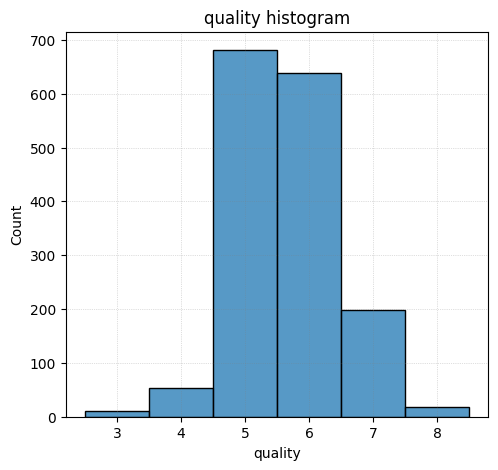

In [5]:
fig = pyplot.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
_ = seaborn.histplot(data=raw_data, x='quality', ax=ax1, binrange=(2.5, 8.5), binwidth=1)
_ = ax1.set_title('quality histogram')
_ = ax1.grid(which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

In [6]:
data = raw_data.copy()
data['class'] = data["quality"].apply(lambda x: 'good' if x >= 7 else 'bad')
_ = data.pop("quality")
data['y'] = (data['class'] == my_class).astype(float)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,class,y
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,bad,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad,0.0


In [7]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,y
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.135710
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.342587
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,0.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


### BALANÇO DE CLASSES

In [8]:
100.0*data.y.value_counts(normalize=True)

y
0.0    86.429018
1.0    13.570982
Name: proportion, dtype: float64

### PairPlot

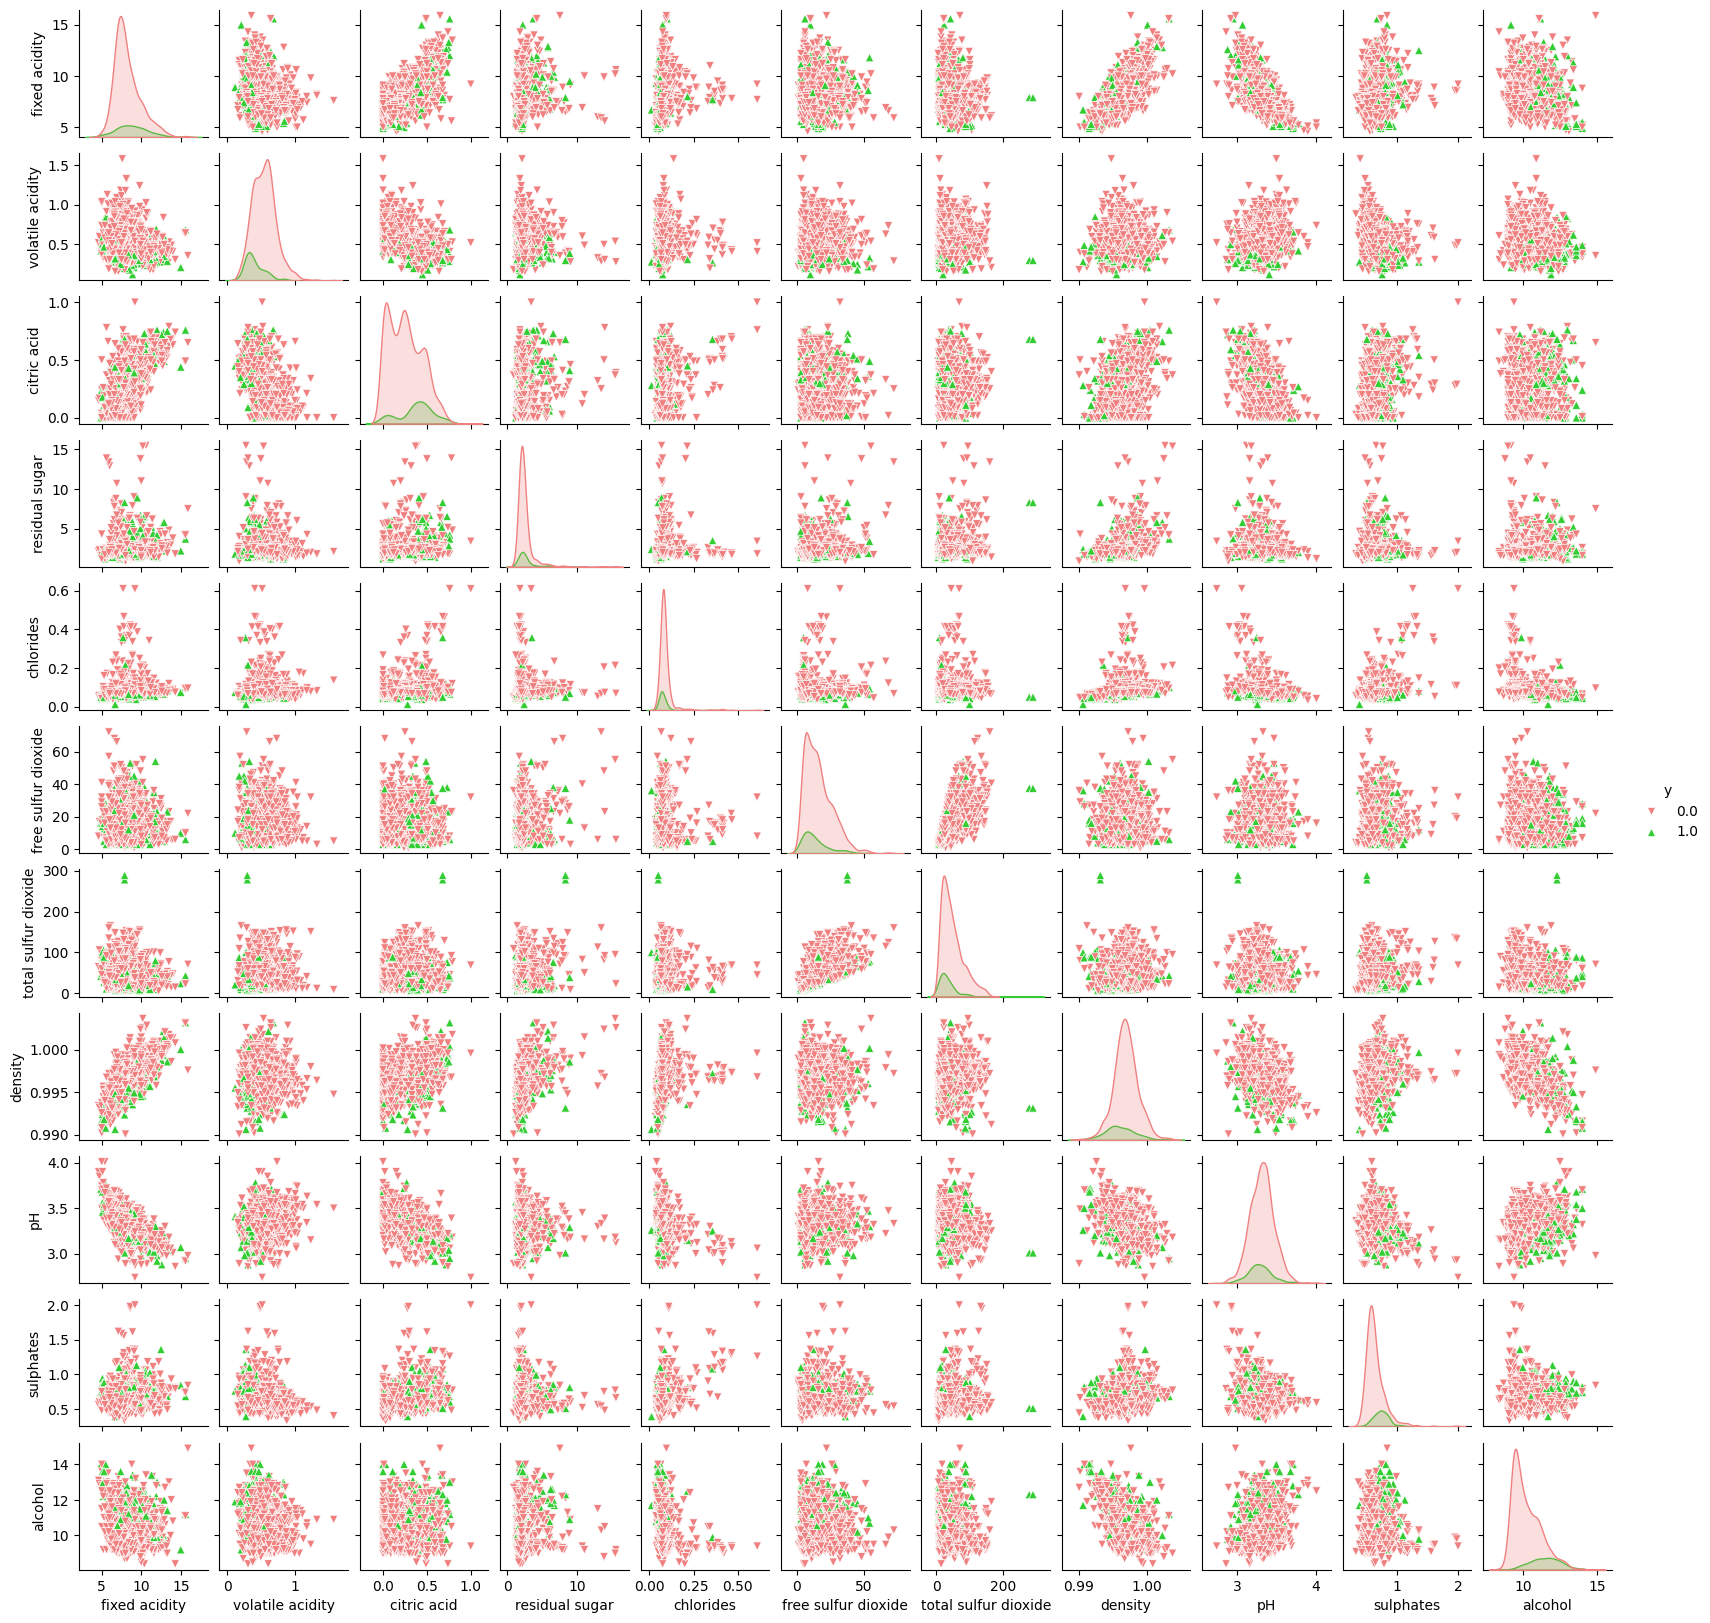

In [9]:
_ = seaborn.pairplot(data, hue='y', height=1.5, palette={0: 'lightcoral', 1: 'limegreen'}, markers=['v', '^'])

### BOXPLOTS VARIAVEIS VS CLASSE

In [10]:
all_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[all_cols])
scaled_data = pandas.DataFrame(scaled_data, columns=all_cols)
scaled_data = scaled_data.join(data['y'])

centers = scaled_data.groupby(['y'])[all_cols].agg(center_stat).T
centers['diff'] = abs(centers[1] - centers[0])
centers = centers.sort_values('diff', ascending=False)

centers

y,0.0,1.0,diff
alcohol,-0.397043,1.104833,1.501876
volatile acidity,0.068040,-0.881661,0.949701
sulphates,-0.343154,0.483029,0.826183
citric acid,-0.159061,0.662546,0.821607
density,0.028261,-0.544154,0.572415
fixed acidity,-0.298547,0.218530,0.517077
total sulfur dioxide,-0.211883,-0.591995,0.380112
free sulfur dioxide,-0.179300,-0.466193,0.286892
pH,-0.007213,-0.266384,0.259171
chlorides,-0.158692,-0.307468,0.148776


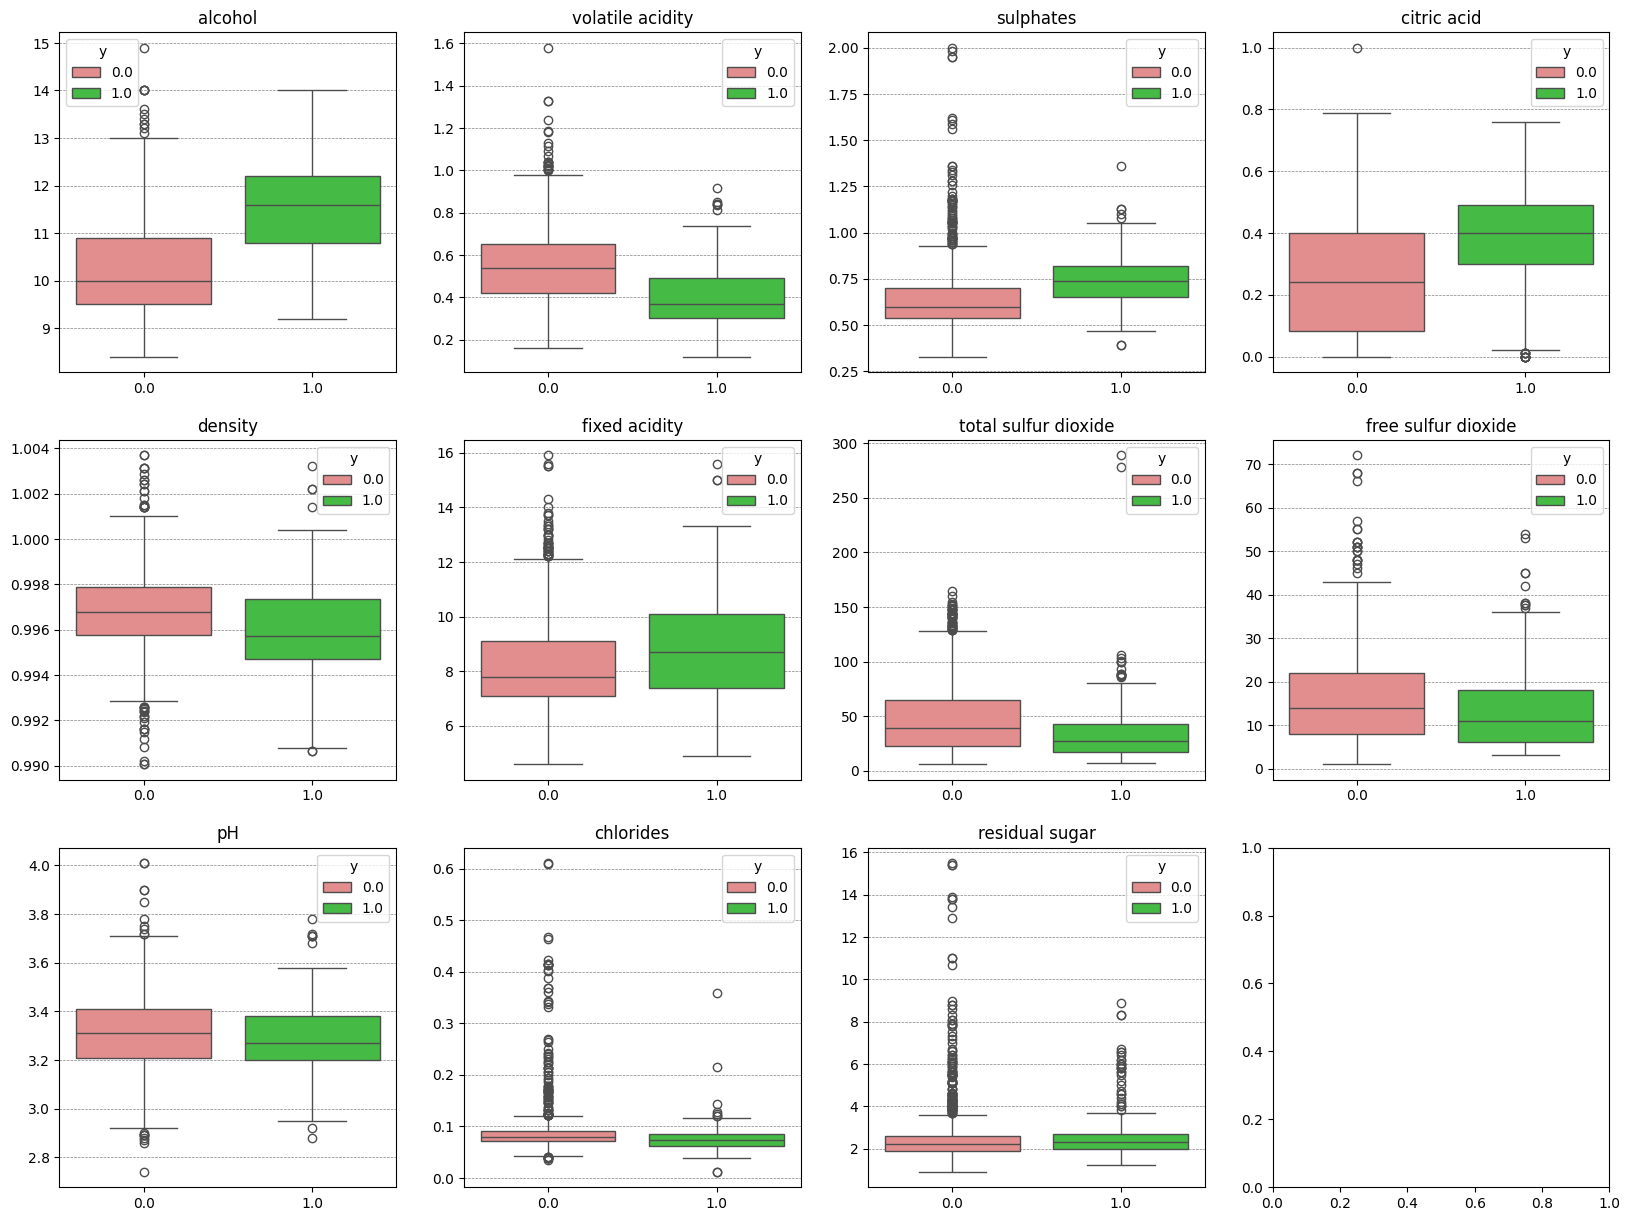

In [11]:
x_cols_sorted = centers['diff'].sort_values(ascending=False).index.tolist()

# BOXPLOT DOS ATRIBUTOS VS CLASSE
fig, axs = pyplot.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axs.flatten()):
    try:
        seaborn.boxplot(x='y', y=x_cols_sorted[i], data=data, ax=ax, hue='y', dodge=False, palette=['lightcoral', 'limegreen'])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(x_cols_sorted[i])
        ax.grid(which='both', axis='y', color='gray', linestyle='--', linewidth=0.5)
    except IndexError:
        pass

### Correlação



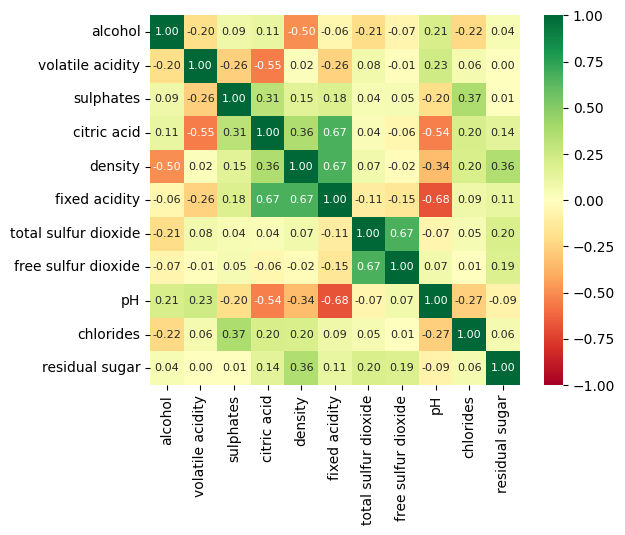

In [12]:
corr_matx = data[x_cols_sorted].corr()
heatmap = seaborn.heatmap(corr_matx,
                          cbar=True,
                          annot=True,
                          square=True,
                          fmt='.2f',
                          annot_kws={'size': 8},
                          yticklabels=x_cols_sorted,
                          xticklabels=x_cols_sorted,
                          cmap='RdYlGn',
                          vmin=-1,
                          vmax=1)

### Classificador

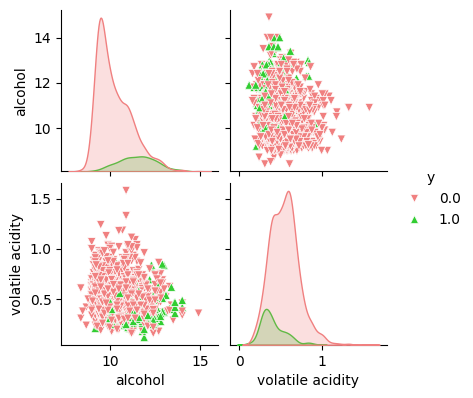

In [13]:
if select_by_center_stat:
    model_cols = x_cols_sorted[:2]
else:
    model_cols = x_cols

_ = seaborn.pairplot(data[model_cols + ['y']], hue='y', height=2.0, palette={0: 'lightcoral', 1: 'limegreen'}, markers=['v', '^'])

In [14]:
# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)
skf = StratifiedKFold(n_splits=n_k_folds, shuffle=True, random_state=random_seed)

result_list = []
fold_ix = 0
for train_index, test_index in skf.split(data[model_cols], data['y']):
    X_train, X_test = data[model_cols].iloc[train_index].to_numpy(), data[model_cols].iloc[test_index].to_numpy()
    y_train, y_test = data['y'].iloc[train_index].to_numpy(), data['y'].iloc[test_index].to_numpy()

    # STANDARD SCALER
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # LDA
    if train_lda:
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train_scaled, y_train)
        y_pred_lda = lda.predict(X_test_scaled)
        lda_train_accuracy = 100.0*lda.score(X_train_scaled, y_train)
        lda_test_accuracy = 100.0*numpy.mean(y_pred_lda == y_test)
        result_list.append({'fold' : fold_ix, 'algorithm' : 'lda', 'hyperparameter' : 0, 'hyperconfig' : 'lda_0', 'model' : lda, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : lda_train_accuracy})
        result_list.append({'fold' : fold_ix, 'algorithm' : 'lda', 'hyperparameter' : 0, 'hyperconfig' : 'lda_0', 'model' : lda, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : lda_test_accuracy})
        print(f'Fold {fold_ix:02d} - LDA - Train: {lda_train_accuracy:.2f} - Test: {lda_test_accuracy:.2f}')

    # QDA
    if train_qda:
        qda = QuadraticDiscriminantAnalysis()
        qda.fit(X_train_scaled, y_train)
        y_pred_qda = qda.predict(X_test_scaled)
        qda_train_accuracy = 100.0*qda.score(X_train_scaled, y_train)
        qda_test_accuracy = 100.0*numpy.mean(y_pred_qda == y_test)
        result_list.append({'fold' : fold_ix, 'algorithm' : 'qda', 'hyperparameter' : 0, 'hyperconfig' : 'qda_0', 'model' : qda, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : qda_train_accuracy})
        result_list.append({'fold' : fold_ix, 'algorithm' : 'qda', 'hyperparameter' : 0, 'hyperconfig' : 'qda_0', 'model' : qda, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : qda_test_accuracy})
        print(f'Fold {fold_ix:02d} - QDA - Train: {qda_train_accuracy:.2f} - Test: {qda_test_accuracy:.2f}')

    # LOGISTIC REGRESSION
    if train_lr:
        lr = LogisticRegression(class_weight='balanced')
        lr.fit(X_train_scaled, y_train)
        y_pred = lr.predict(X_test_scaled)
        lr_train_accuracy = 100.0*lr.score(X_train_scaled, y_train)
        lr_test_accuracy = 100.0*numpy.mean(y_pred == y_test)
        result_list.append({'fold' : fold_ix, 'algorithm' : 'lr', 'hyperparameter' : 0, 'hyperconfig' : 'lr_0', 'model' : lr, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : lr_train_accuracy})
        result_list.append({'fold' : fold_ix, 'algorithm' : 'lr', 'hyperparameter' : 0, 'hyperconfig' : 'lr_0', 'model' : lr, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : lr_test_accuracy})
        print(f'Fold {fold_ix:02d} - LR - Train: {lr_train_accuracy:.2f} - Test: {lr_test_accuracy:.2f}')


    # TREES AND FORESTS
    if train_tree or train_forest:
        if tree_hyperparameter == 'max_depth':
            hyper_parameter_range = decision_tree_max_depth
        else:
            hyper_parameter_range = decision_tree_min_samples_leaf_range      
  
        if train_tree:
            for hyperparameter in hyper_parameter_range:
                if tree_hyperparameter == 'max_depth':
                    dt = tree.DecisionTreeClassifier(criterion=tree_criteria, max_depth=hyperparameter)
                elif tree_hyperparameter == 'min_samples_leaf':
                    dt = tree.DecisionTreeClassifier(criterion=tree_criteria, min_samples_leaf=hyperparameter) # class_weight='balanced'
                else:
                    raise ValueError('Invalid hyperparameter')
                dt.fit(X_train_scaled, y_train)
                y_pred = dt.predict(X_test_scaled)
                train_accuracy = 100.0*dt.score(X_train_scaled, y_train)
                test_accuracy = 100.0*numpy.mean(y_pred == y_test)
                result_list.append({'fold' : fold_ix, 'algorithm' : 'tree', 'hyperparameter' : hyperparameter, 'hyperconfig' : f'tree_{hyperparameter:02d}', 'model' : dt, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : train_accuracy})
                result_list.append({'fold' : fold_ix, 'algorithm' : 'tree', 'hyperparameter' : hyperparameter, 'hyperconfig' : f'tree_{hyperparameter:02d}', 'model' : dt, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : test_accuracy})
                print(f'Fold {fold_ix:02d} - DT - Hyperparameter: {hyperparameter:02d} - Train: {train_accuracy:.2f} - Test: {test_accuracy:.2f}')

        # RANDOM FOREST
        if train_forest:
            for hyperparameter in hyper_parameter_range:
                for n_estimator in n_estimators:
                    if tree_hyperparameter == 'max_depth':
                        rf = RandomForestClassifier(n_estimators=n_estimator, criterion=tree_criteria, max_depth=hyperparameter, random_state=random_seed)
                    elif tree_hyperparameter == 'min_samples_leaf':
                        rf = RandomForestClassifier(n_estimators=n_estimator, criterion=tree_criteria, min_samples_leaf=hyperparameter, random_state=random_seed)

                    rf.fit(X_train_scaled, y_train)
                    y_pred = rf.predict(X_test_scaled)
                    train_accuracy = 100.0*rf.score(X_train_scaled, y_train)
                    test_accuracy = 100.0*numpy.mean(y_pred == y_test)
                    result_list.append({'fold' : fold_ix, 'algorithm' : 'rf', 'hyperparameter' : n_estimator, 'hyperconfig' : f'rf_{n_estimator:02d}_{hyperparameter:02d}', 'model' : rf, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : train_accuracy})
                    result_list.append({'fold' : fold_ix, 'algorithm' : 'rf', 'hyperparameter' : n_estimator, 'hyperconfig' : f'rf_{n_estimator:02d}_{hyperparameter:02d}', 'model' : rf, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : test_accuracy})
                    print(f'Fold {fold_ix:02d} - RF - Hyperparameter: {n_estimator:02d}-{hyperparameter:02d} - Train: {train_accuracy:.2f} - Test: {test_accuracy:.2f}')

    # NEURAL NETWORK
    if train_nn:
        for n_hidden_layers in n_hidden_layers_range:
            # DECLARE NETWORK
            inputs = keras.layers.Input(shape=(X_train_scaled.shape[1],))
            hidden = keras.layers.Dense(n_hidden_layers, activation=activation)(inputs)
            outputs = keras.layers.Dense(1, activation='sigmoid')(hidden)
            model_name = f'nn_{n_hidden_layers:02d}'
            nn = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
            nn.compile(optimizer=optimizer, loss=loss, metrics=[metric])
            es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
            # es_metric = keras.callbacks.EarlyStopping(monitor=metric, mode='max', patience=patience, min_delta=min_improvement, restore_best_weights=True)
            es_val_metric = keras.callbacks.EarlyStopping(monitor=f'val_{metric}', mode='max', patience=2*patience, min_delta=min_improvement, restore_best_weights=True)

            # FIT W CLASS WEIGHTS
            my_class_weight = y_train.shape[0]/y_train.sum()
            other_class_weight = y_train.shape[0]/(y_train==0).sum()
            class_weights = {0: other_class_weight, 1: my_class_weight}
            history = nn.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=max_epochs, batch_size=batch_size, callbacks=[es_loss, es_val_metric], verbose=verbose, class_weight=class_weights)

            # UNPACK TRAINING RESULTS
            train_accuracy = 100.0*history.history['accuracy'][-1]
            test_accuracy = 100.0*history.history['val_accuracy'][-1]
            result_list.append({'fold' : fold_ix, 'algorithm' : 'nn', 'hyperparameter' : n_hidden_layers, 'hyperconfig' : f'nn_{n_hidden_layers:02d}', 'model' : nn, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : train_accuracy})
            result_list.append({'fold' : fold_ix, 'algorithm' : 'nn', 'hyperparameter' : n_hidden_layers, 'hyperconfig' : f'nn_{n_hidden_layers:02d}', 'model' : nn, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : test_accuracy})
            print(f'Fold {fold_ix:02d} - NN - Hyperparameter: {n_hidden_layers:02d} - Train: {train_accuracy:.2f} - Test: {test_accuracy:.2f} - Epochs {len(history.epoch)}')

    fold_ix += 1
    

Fold 00 - LDA - Train: 86.47 - Test: 83.75
Fold 00 - QDA - Train: 86.08 - Test: 84.38
Fold 00 - LR - Train: 78.50 - Test: 77.19
Fold 00 - DT - Hyperparameter: 02 - Train: 86.40 - Test: 86.56
Fold 00 - DT - Hyperparameter: 03 - Train: 87.49 - Test: 86.25
Fold 00 - DT - Hyperparameter: 04 - Train: 88.04 - Test: 85.94
Fold 00 - RF - Hyperparameter: 02-02 - Train: 86.40 - Test: 86.56
Fold 00 - RF - Hyperparameter: 03-02 - Train: 86.40 - Test: 86.56
Fold 00 - RF - Hyperparameter: 04-02 - Train: 86.40 - Test: 86.56
Fold 00 - RF - Hyperparameter: 02-03 - Train: 86.63 - Test: 86.88
Fold 00 - RF - Hyperparameter: 03-03 - Train: 86.94 - Test: 87.19
Fold 00 - RF - Hyperparameter: 04-03 - Train: 87.72 - Test: 87.19
Fold 00 - RF - Hyperparameter: 02-04 - Train: 88.12 - Test: 85.31
Fold 00 - RF - Hyperparameter: 03-04 - Train: 88.12 - Test: 86.56
Fold 00 - RF - Hyperparameter: 04-04 - Train: 88.90 - Test: 85.31


2024-07-01 15:23:12.735737: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 15:23:12.736146: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Fold 00 - NN - Hyperparameter: 02 - Train: 76.62 - Test: 76.25 - Epochs 370
Fold 00 - NN - Hyperparameter: 03 - Train: 76.62 - Test: 76.25 - Epochs 366
Fold 00 - NN - Hyperparameter: 04 - Train: 77.40 - Test: 76.56 - Epochs 414
Fold 00 - NN - Hyperparameter: 05 - Train: 78.26 - Test: 77.50 - Epochs 543
Fold 01 - LDA - Train: 85.93 - Test: 87.50
Fold 01 - QDA - Train: 85.77 - Test: 87.50
Fold 01 - LR - Train: 77.95 - Test: 78.44
Fold 01 - DT - Hyperparameter: 02 - Train: 86.40 - Test: 86.56
Fold 01 - DT - Hyperparameter: 03 - Train: 86.71 - Test: 84.69
Fold 01 - DT - Hyperparameter: 04 - Train: 87.65 - Test: 86.88
Fold 01 - RF - Hyperparameter: 02-02 - Train: 86.40 - Test: 86.56
Fold 01 - RF - Hyperparameter: 03-02 - Train: 86.40 - Test: 86.56
Fold 01 - RF - Hyperparameter: 04-02 - Train: 86.40 - Test: 86.56
Fold 01 - RF - Hyperparameter: 02-03 - Train: 87.65 - Test: 86.56
Fold 01 - RF - Hyperparameter: 03-03 - Train: 87.65 - Test: 86.56
Fold 01 - RF - Hyperparameter: 04-03 - Train: 87.

In [15]:
df_results = pandas.DataFrame(result_list).sort_values(['accuracy', 'stat'], ascending=[False, True])

df_results

,fold,algorithm,hyperparameter,hyperconfig,model,scaler,stat,accuracy
28,0,rf,4,rf_04_04,"(DecisionTreeClassifier(criterion='entropy', m...",StandardScaler(),train,88.897576
179,4,rf,3,rf_03_04,"(DecisionTreeClassifier(criterion='entropy', m...",StandardScaler(),test,88.401254
140,3,rf,3,rf_03_04,"(DecisionTreeClassifier(criterion='entropy', m...",StandardScaler(),train,88.193901
142,3,rf,4,rf_04_04,"(DecisionTreeClassifier(criterion='entropy', m...",StandardScaler(),train,88.193901
77,2,lda,0,lda_0,LinearDiscriminantAnalysis(),StandardScaler(),test,88.125000
...,...,...,...,...,...,...,...,...
151,3,nn,5,nn_05,"<Functional name=nn_05, built=True>",StandardScaler(),test,74.374998
188,4,nn,5,nn_05,"<Functional name=nn_05, built=True>",StandardScaler(),train,74.218750
147,3,nn,3,nn_03,"<Functional name=nn_03, built=True>",StandardScaler(),test,74.062502
183,4,nn,2,nn_02,"<Functional name=nn_02, built=True>",StandardScaler(),test,73.981190


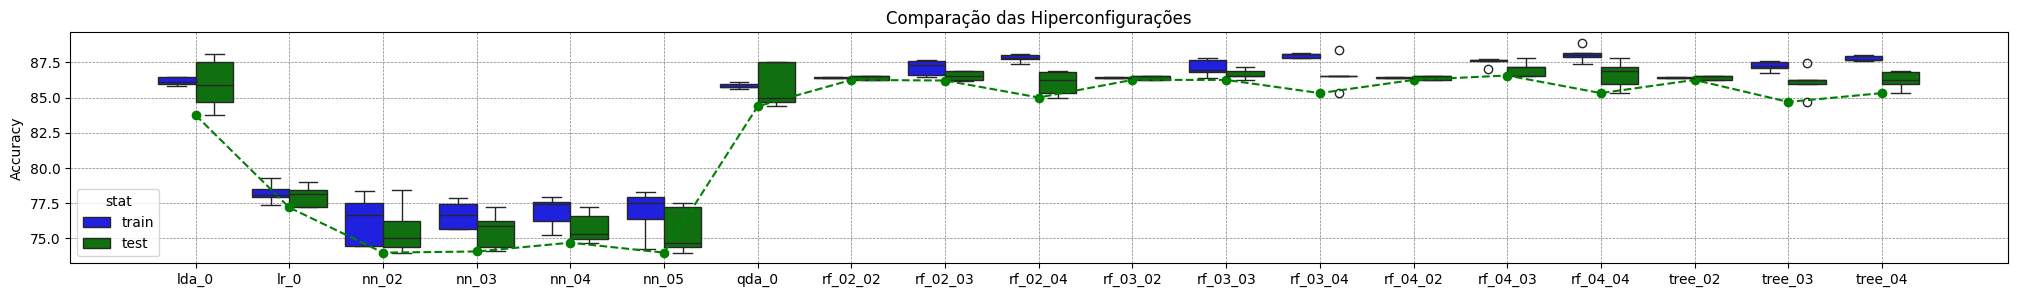

In [16]:
# BOXPLOT LDA VS LR FOR TRAIN AND TEST ACCURACY
hyperconfigs = df_results.hyperconfig.sort_values().unique()
min_accuracies = df_results.groupby('hyperconfig')['accuracy'].agg('min')
fig = pyplot.figure(figsize=(25, 3))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(x='hyperconfig', y='accuracy', data=df_results, hue='stat', palette=['blue', 'green'], order=hyperconfigs, ax=ax, hue_order=['train', 'test'])
ax.plot(hyperconfigs, min_accuracies, ls='--', marker='o', color='green', label='min accuracy')
ax.set_title('Comparação das Hiperconfigurações')
ax.set_ylabel('Accuracy')
ax.set_xlabel('')
ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

In [17]:
# PICK THE BEST MODEL BY THE LOWER BOUND OF THE TEST ACCURACY
df_grouped = df_results.groupby(['hyperconfig', 'stat']).agg({'accuracy' : ['mean', 'std']}).reset_index()
df_grouped.columns = ['hyperconfig', 'stat', 'mean_accuracy', 'std_accuracy']
df_grouped['lower_bound'] = df_grouped['mean_accuracy'] - n_std_lower_bound*df_grouped['std_accuracy']
df_grouped = df_grouped.sort_values(['lower_bound', 'hyperconfig'], ascending=[False, True])

df_grouped

,hyperconfig,stat,mean_accuracy,std_accuracy,lower_bound
25,rf_03_04,train,88.008112,0.189687,87.439051
37,tree_04,train,87.773639,0.208943,87.146811
19,rf_02_04,train,87.820514,0.278531,86.984921
29,rf_04_03,train,87.523444,0.285570,86.666733
31,rf_04_04,train,88.086310,0.540373,86.465192
15,rf_02_02,train,86.429022,0.041113,86.305681
21,rf_03_02,train,86.429022,0.041113,86.305681
27,rf_04_02,train,86.429022,0.041113,86.305681
33,tree_02,train,86.429022,0.041113,86.305681
35,tree_03,train,87.226385,0.343741,86.195163


In [18]:
is_test = df_grouped['stat'] == 'test'
best_hyperconfig = df_grouped.loc[is_test, 'hyperconfig'].values[0]
best_hyperconfig_stats = df_grouped.loc[is_test & (df_grouped['hyperconfig'] == best_hyperconfig), ['mean_accuracy', 'std_accuracy', 'lower_bound']].values[0]

print(f'Melhor HyperConfig foi {best_hyperconfig} com média de acurácia de {best_hyperconfig_stats[0]:.2f} +/- {best_hyperconfig_stats[1]:.2f} e limite inferior de {best_hyperconfig_stats[2]:.2f}')

Melhor HyperConfig foi rf_02_02 com média de acurácia de 86.43 +/- 0.16 e limite inferior de 85.94


### RE-TREINO DO MELHOR MODELO

In [19]:
# PICK THE BEST MODEL
is_best_model = (df_results['hyperconfig'] == best_hyperconfig) & (df_results['stat'] == 'test')
best_algorithm = df_results.loc[is_best_model, 'algorithm'].values[0]
best_scaler = df_results.loc[is_best_model, 'scaler'].values[0]
best_model = df_results.loc[is_best_model, 'model'].values[0]

print(f'Melhor modelo foi {best_model}')

Melhor modelo foi RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=2,
                       random_state=42)


In [20]:
# RETRAIN BEST MODEL
X = data[model_cols].to_numpy()
y = data['y'].to_numpy()
X_scaled = best_scaler.fit_transform(X)
best_model.fit(X_scaled, y)
if best_algorithm == 'nn':
    y_pred = best_model.predict(X_scaled, verbose=0).flatten()
else:
    best_model.fit(X_scaled, y)
    y_pred = best_model.predict(X_scaled)

best_accuracy = 100.0*numpy.mean((y_pred > 0.5).astype(int) == y)

print(f'Acurácia do melhor modelo foi {best_accuracy:.2f}')

Acurácia do melhor modelo foi 87.49


### VISUALIZAR SEPARADOR, MATRIZ DE CONFUSÃO E ROC

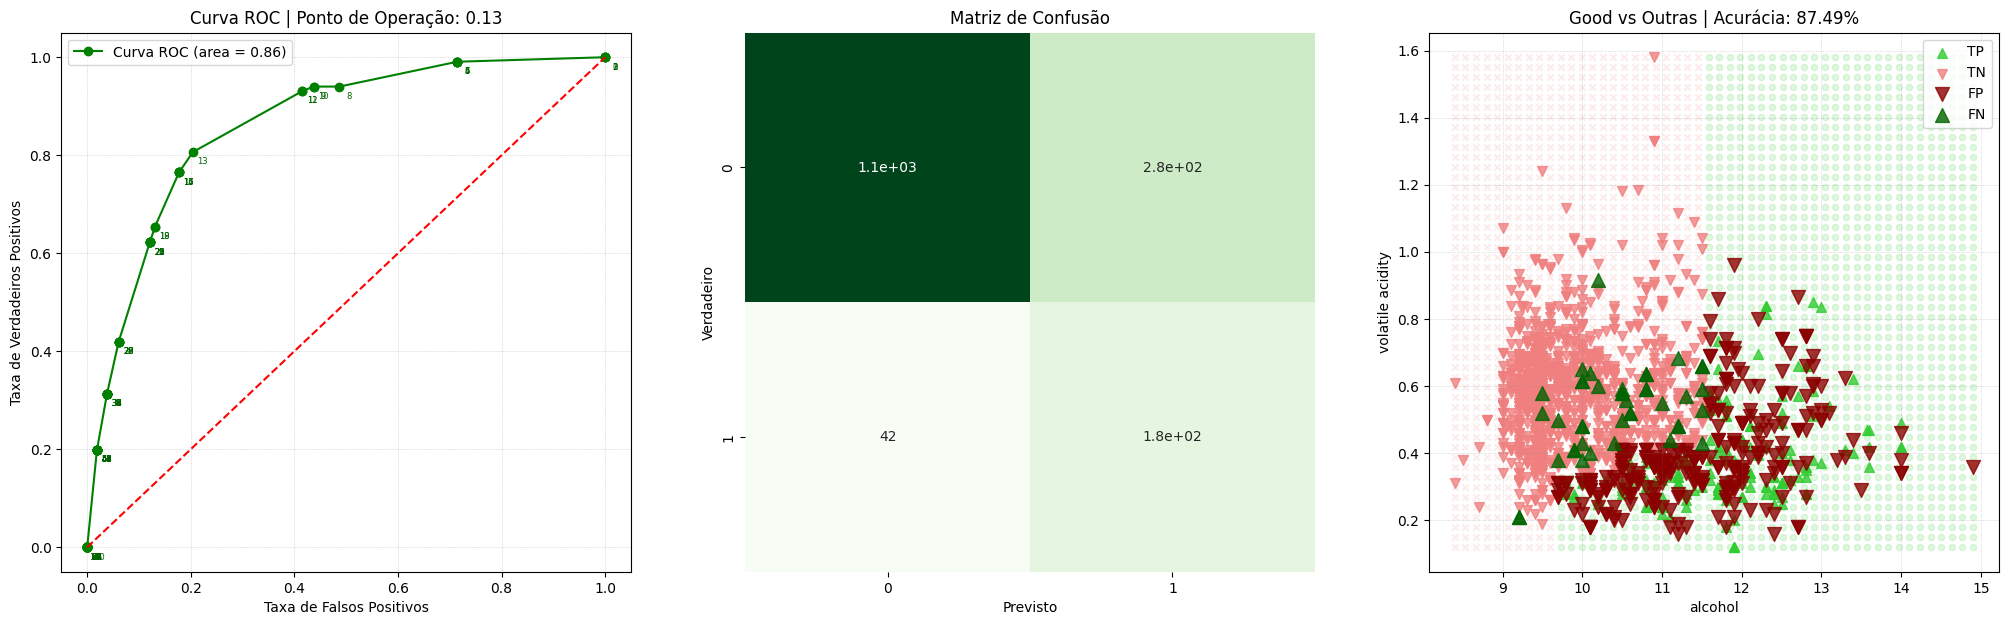

In [21]:
x_col = model_cols[0]
y_col = model_cols[1]

linspace_points = 50
roc_thresholds = 100

# PLOT ROC
if best_algorithm == 'nn':
    y_pred_proba = best_model.predict(X_scaled, verbose=0).flatten()
else:
    y_pred_proba = best_model.predict_proba(X_scaled)[:,1]    

proba_linspace = numpy.linspace(0, 1, roc_thresholds)

roc_points = []
for i, threshold in enumerate(proba_linspace):
    y_pred = (y_pred_proba > threshold).astype(float)
    tp = numpy.sum((y == 1) & (y_pred == 1))
    tn = numpy.sum((y == 0) & (y_pred == 0))
    fp = numpy.sum((y == 0) & (y_pred == 1))
    fn = numpy.sum((y == 1) & (y_pred == 0))
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    roc_points.append((threshold, fpr, tpr))

if change_operation_point:
    best_operation_point = max(roc_points, key=lambda x: x[2] - x[1])
else:
    best_operation_point = (0.5, 0.5, 0.5)
    
y_pred_operation = (y_pred_proba > best_operation_point[0]).astype(float)

fig = pyplot.figure(figsize=(25, 7))
# PLOT AND ANNOTATE ROC CURVE
ax = fig.add_subplot(131)
_ = ax.plot([x[1] for x in roc_points], [x[2] for x in roc_points], color='green', label=f'Curva ROC (area = {roc_auc_score(y, y_pred_proba):.2f})', marker='o')
_ = ax.plot([0, 1], [0, 1], color='red', linestyle='--')
_ = ax.set_xlabel('Taxa de Falsos Positivos')
_ = ax.set_ylabel('Taxa de Verdadeiros Positivos')
_ = ax.set_title(f'Curva ROC | Ponto de Operação: {best_operation_point[0]:.2f}')
_ = ax.legend()
_ = ax.grid(which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
# ANNOTATE ROC CURVE
for i, threshold in enumerate(proba_linspace):
    ax.annotate(f'{100.0*threshold:.0f}', (roc_points[i][1], roc_points[i][2]), textcoords='offset points', xytext=(7, -7), ha='center', va='center', fontsize=6, color='darkgreen')

# PLOT CONFUSION MATRIX
conf_matrix = confusion_matrix(y, y_pred_operation)

ax = fig.add_subplot(132)
_ = seaborn.heatmap(conf_matrix, annot=True, cmap='Greens', cbar=False, ax=ax)
_ = ax.set_xlabel('Previsto')
_ = ax.set_ylabel('Verdadeiro')
_ = ax.set_title('Matriz de Confusão')

class_areas_list = []
linspace_point_list = []
for x_i in numpy.linspace(data[x_col].min(),data[x_col].max(), linspace_points):
    for y_i in numpy.linspace(data[y_col].min(),data[y_col].max(), linspace_points):
        if best_algorithm == 'nn':
            p_i = best_model.predict(best_scaler.transform([[x_i, y_i]]), verbose=0).flatten()[0]
        else:
            p_i = best_model.predict_proba(best_scaler.transform([[x_i, y_i]]))[0][1]

        if p_i > best_operation_point[0]:
            c_i = 1
        else:
            c_i = 0

        class_areas_list.append({'x': x_i, 'y': y_i, 'c': c_i, 'p': p_i})

class_areas_df = pandas.DataFrame(class_areas_list)
ax = fig.add_subplot(133)
_ = class_areas_df[class_areas_df['c'] == 0].plot.scatter(x='x', y='y', color='lightcoral', ax=ax, alpha=0.15, marker='x')
_ = class_areas_df[class_areas_df['c'] == 1].plot.scatter(x='x', y='y', color='limegreen', ax=ax, alpha=0.15, marker='o')

# PLOT TRUE POSITIVES
_ = data[(data['y'] == 1.0) & (y_pred_operation == 1.0)].plot.scatter(x=x_col,y=y_col, color='limegreen', label='TP', ax=ax, s=50, alpha=0.8, marker='^')
# PLOT TRUE NEGATIVES
_ = data[(data['y'] == 0.0) & (y_pred_operation == 0.0)].plot.scatter(x=x_col,y=y_col, color='lightcoral', label='TN', ax=ax, s=50, marker='v', alpha=0.8)
# PLOT FALSE POSITIVES
_ = data[(data['y'] == 0.0) & (y_pred_operation == 1.0)].plot.scatter(x=x_col,y=y_col, color='darkred', label='FP', ax=ax, s=100, alpha=0.8, marker='v')
# PLOT FALSE NEGATIVES
_ = data[(data['y'] == 1.0) & (y_pred_operation == 0.0)].plot.scatter(x=x_col,y=y_col, color='darkgreen', label='FN', ax=ax, s=100, alpha=0.8, marker='^')
_ = ax.set_title(f"{my_class.capitalize()} vs Outras | Acurácia: {best_accuracy:.2f}%")
_ = ax.grid(which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

### RE-TREINAR E PLOTAR A MELHOR RANDOM FOREST

In [26]:
is_best_random_forest_hyperconfig = df_grouped.hyperconfig.str.contains('rf') & (df_grouped['stat'] == 'test')
best_random_forest_hyperconfig = df_grouped.loc[is_best_random_forest_hyperconfig, 'hyperconfig'].values[0]

best_random_forest_hyperconfig

'rf_02_02'

In [27]:
is_best_random_forest = (df_results['hyperconfig'] == best_random_forest_hyperconfig) & (df_results['stat'] == 'test')
best_random_forest_model = df_results.loc[is_best_random_forest, 'model'].values[0]

print(f'Melhor modelo de random forest foi {best_random_forest_model}')

Melhor modelo de random forest foi RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=2,
                       random_state=42)


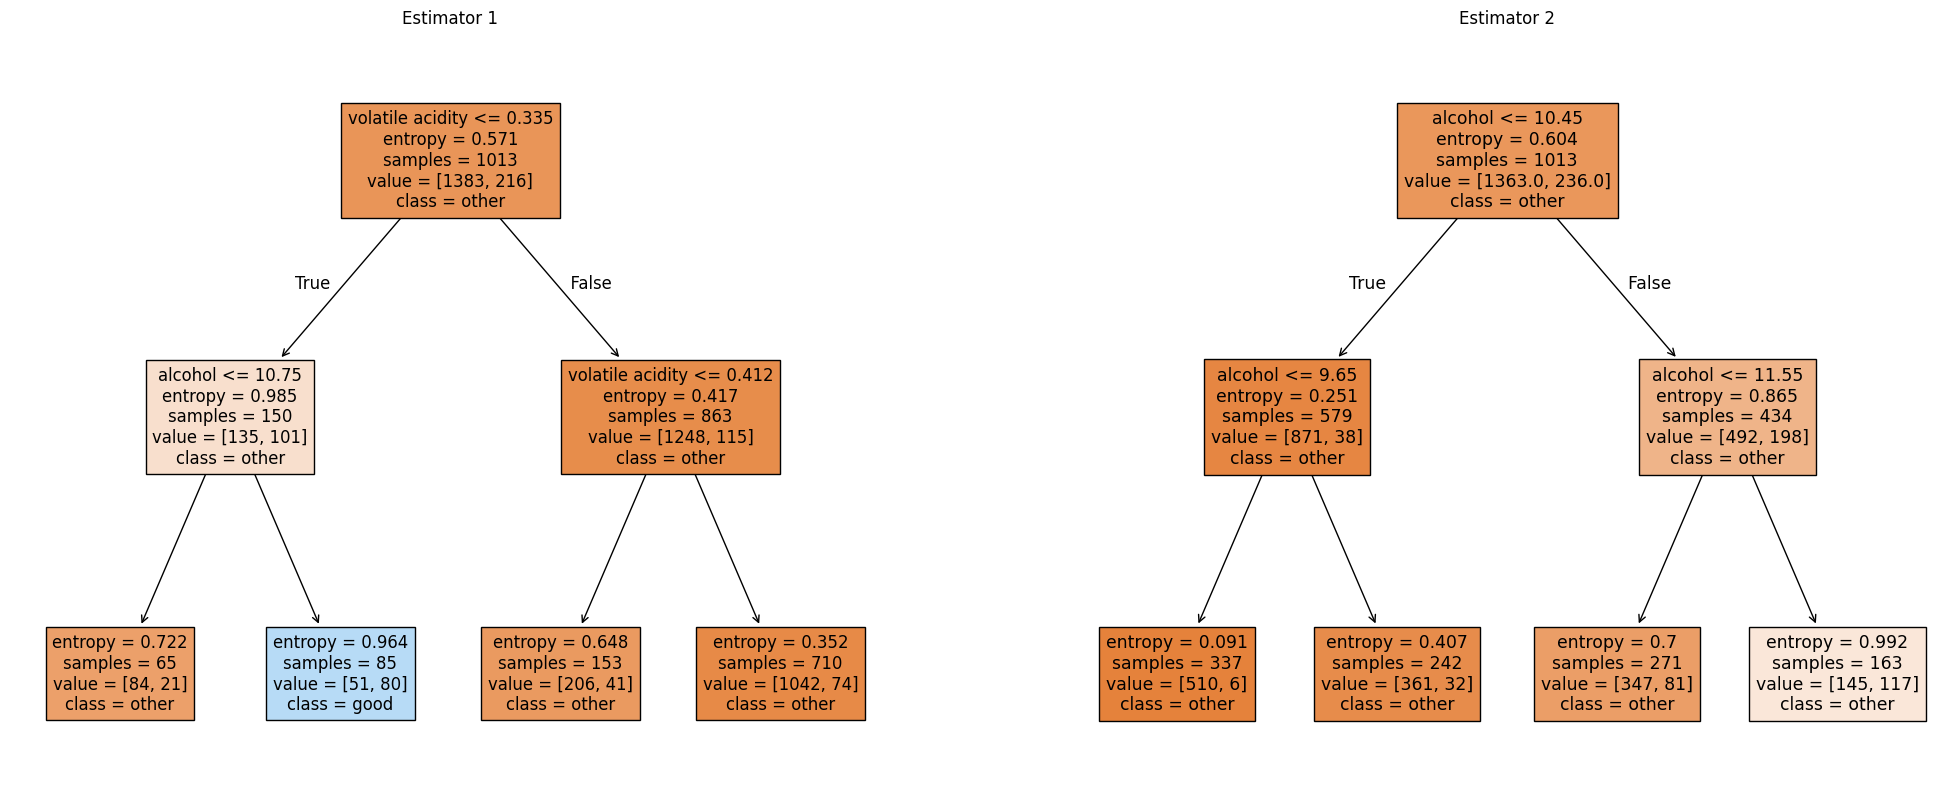

In [28]:
best_random_forest_model.fit(X, y)

# PLOT ALL ESTIMATORS
fig = pyplot.figure(figsize=(25, 10))
for i, tree_in_forest in enumerate(best_random_forest_model.estimators_):
    ax = fig.add_subplot(1, len(best_random_forest_model.estimators_), i+1)
    _ = tree.plot_tree(tree_in_forest, feature_names=model_cols, class_names=['other', my_class], filled=True, ax=ax)
    ax.set_title(f'Estimator {i+1}')